In [1]:
import numpy as np
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, recall_score, precision_score,make_scorer
from sklearn.decomposition import PCA
import seaborn as sns
sns.set(color_codes=True)
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
np.random.seed(25)
import os
import warnings 
warnings.filterwarnings("ignore")
from fbprophet import Prophet

In [2]:
train1 = pd.read_csv('../input/price-movement-data/b553a8fc-2-dataset/dataset/train/train1.csv')
train2 = pd.read_csv('../input/price-movement-data/b553a8fc-2-dataset/dataset/train/train2.csv')
train3 = pd.read_csv('../input/price-movement-data/b553a8fc-2-dataset/dataset/train/train3.csv')
test1 = pd.read_csv('../input/price-movement-data/b553a8fc-2-dataset/dataset/test/test1.csv')
test2 = pd.read_csv('../input/price-movement-data/b553a8fc-2-dataset/dataset/test/test2.csv')
test3 = pd.read_csv('../input/price-movement-data/b553a8fc-2-dataset/dataset/test/test3.csv')

In [3]:
temp_df = pd.read_csv('../input/temp-df/temp_df.csv')

In [4]:
train = train1.append([train2,train3], ignore_index=True)
test = test1.append([test2,test3], ignore_index=True)

In [5]:
train.head()

,UID,Date,Time,MidPrice,Symbol,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11,Feature12,Feature13,Feature14,Feature15,Feature16,Feature17,Feature18,Feature19,Feature20,Feature21,Feature22,Feature23,Feature24,Feature25,Feature26,Feature27,Feature28,Feature29,Feature30,Feature31,Feature32,Feature33,Feature34,Feature35,Feature36,Feature37,Feature38,Feature39,Feature40,Feature41,Feature42,Feature43,Feature44,Feature45,Feature46
0,04-01-2015 09:20 und_109,04-01-2015,09:20,1701.00,und_109,0.556213,0.504202,0.996146,0.993157,1.003206,0.995698,0.996728,0.996247,-0.308824,-0.302752,-0.186813,-0.292308,0.180492,0.013714,-0.733206,-0.781319,0.482014,0.462366,-1.082274,-1.753641,-1.078707,0.501600,0.343173,0.309610,0.206452,0.000563,0.000244,0.000261,0.000130,1.008413,1.173405,1.976990,1.450977,1.012734,1.009129,1.026050,1.016019,1.053254,0.942061,0.811770,0.735862,0.452454,0.901639,0.592593,0.463768,0.373913
1,04-01-2015 09:25 und_109,04-01-2015,09:25,1696.55,und_109,0.551020,0.450704,0.997270,0.993206,0.999403,0.994075,0.962433,0.995417,-0.312500,-0.312500,-0.235294,-0.283951,0.109091,0.040043,-0.774026,-0.836580,0.660377,0.594059,-0.936508,-1.744938,-0.584546,0.478699,0.374552,0.376217,0.270891,0.000104,0.000229,0.000197,0.000070,0.548042,1.108665,1.261438,1.122638,1.012989,1.008484,1.025488,1.016547,1.051948,0.860435,0.890110,0.728061,0.704193,1.064024,0.500000,0.410959,0.445255
2,04-01-2015 09:30 und_109,04-01-2015,09:30,1699.65,und_109,0.611111,0.520548,0.995962,0.993040,1.001903,0.993944,0.965953,0.997971,-0.243902,-0.242424,-0.163636,-0.301205,0.114485,-0.078537,-0.581278,-0.726341,0.710843,0.495495,-0.775941,-1.375991,-0.609353,0.476861,0.324236,0.312375,0.216826,0.000009,0.000186,0.000171,0.000065,0.602466,1.274973,1.754310,1.141958,1.012233,1.008618,1.024957,1.016253,1.005376,0.853699,0.850242,0.724241,0.568616,1.240418,0.750000,0.594203,0.517730
3,04-01-2015 09:35 und_109,04-01-2015,09:35,1697.05,und_109,0.538462,0.441558,0.996669,0.995334,1.005164,0.993557,0.962999,0.996606,-0.312883,-0.312977,-0.181818,-0.317647,0.196095,-0.006718,-0.740154,-0.907235,0.630058,0.453704,-1.020604,-1.836325,-0.707589,0.523597,0.390531,0.403055,0.355621,0.000106,0.000242,0.000263,0.000073,0.562495,1.063779,1.979256,0.736998,1.014070,1.009994,1.028127,1.017669,1.028846,0.843867,0.777778,0.637807,0.546903,1.291815,0.500000,0.426667,0.344595
4,04-01-2015 09:40 und_109,04-01-2015,09:40,1695.40,und_109,0.598086,0.506410,0.994673,0.991444,1.002091,0.991847,0.961128,0.995751,-0.235294,-0.235294,-0.130435,-0.264368,0.150183,-0.039377,-0.523810,-0.676740,0.701149,0.570093,-0.808268,-1.420480,-0.526474,0.411008,0.320000,0.329287,0.252664,-0.000075,0.000140,0.000146,-0.000010,0.562422,1.225252,1.906995,1.046772,1.011688,1.007766,1.023151,1.015709,0.966139,0.818047,0.777512,0.658333,1.01903,1.589147,0.575758,0.554054,0.410596


In [6]:
test.head()

,UID,Date,Time,Symbol,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11,Feature12,Feature13,Feature14,Feature15,Feature16,Feature17,Feature18,Feature19,Feature20,Feature21,Feature22,Feature23,Feature24,Feature25,Feature26,Feature27,Feature28,Feature29,Feature30,Feature31,Feature32,Feature33,Feature34,Feature35,Feature36,Feature37,Feature38,Feature39,Feature40,Feature41,Feature42,Feature43,Feature44,Feature45,Feature46
0,01-06-2015 09:20 und_109,01-06-2015,09:20,und_109,1.047619,0.838235,0.995017,0.994663,1.007941,0.992888,0.987429,0.992261,-0.152941,-0.147059,0.080000,-0.121951,0.280612,0.030946,-0.087868,-0.331565,0.824324,0.808511,-0.114719,-0.401187,-0.256978,0.549273,0.332003,0.396409,0.361702,0.000234,0.000087,0.000185,-0.000187,0.880706,0.915788,2.971553,0.774915,1.009460,1.006770,1.024586,1.016458,1.425926,1.127282,0.892416,0.714052,0.547035,2.213974,0.888889,0.638298,0.833333
1,01-06-2015 09:25 und_109,01-06-2015,09:25,und_109,0.538961,0.400000,0.994234,0.991318,1.000569,0.988476,0.960593,0.985498,-0.456000,-0.460000,-0.297297,-0.377049,0.237233,0.128361,-1.126050,-1.295282,0.434109,0.514706,-1.190581,-2.050000,-0.942968,0.485332,0.274935,0.292337,0.238710,0.000726,0.000508,0.000458,0.000008,0.611066,0.817690,1.498452,0.727969,1.010290,1.008207,1.025994,1.015297,1.442513,1.081481,0.995005,0.738462,0.62919,2.153846,0.500000,0.333333,0.421488
2,01-06-2015 09:30 und_109,01-06-2015,09:30,und_109,1.164384,0.991935,0.997802,0.999094,0.997504,0.993885,0.965821,0.985948,-0.058065,-0.064516,0.046512,-0.072464,0.116438,-0.008882,-0.012863,-0.153083,1.144000,1.172840,0.244158,0.136966,0.193566,0.454459,0.423254,0.492701,0.474629,-0.000363,-0.000163,-0.000101,-0.000121,0.614032,0.600959,0.967897,0.400654,1.012886,1.010663,1.020956,1.017233,1.307938,1.128754,1.060883,0.903763,1.54522,1.946429,0.647059,0.972973,0.983333
3,01-06-2015 09:35 und_109,01-06-2015,09:35,und_109,1.082278,0.940741,1.002913,1.002629,1.002901,0.998327,0.970138,0.993847,-0.088608,-0.086614,0.023810,-0.088235,0.120478,-0.001749,-0.069444,-0.188656,1.028571,0.855769,0.092679,-0.035696,-0.086508,0.562008,0.546888,0.671246,0.662256,-0.000231,-0.000003,0.000048,0.000025,0.612402,0.722752,1.001814,0.512039,1.011773,1.009465,1.020192,1.016350,1.292722,1.119157,1.031940,0.896985,1.45107,1.582090,0.609756,0.890244,0.944882
4,01-06-2015 09:40 und_109,01-06-2015,09:40,und_109,1.040936,0.897260,0.998457,0.998693,0.998132,0.992841,0.966455,0.992993,-0.108571,-0.114286,-0.062500,-0.179487,0.051150,-0.073615,-0.189929,-0.331679,1.166667,1.065217,0.180695,0.053592,0.127619,0.449169,0.408171,0.506019,0.460110,-0.000219,0.000006,0.000012,-0.000059,0.614435,0.795604,0.968658,0.368011,1.011912,1.009584,1.020719,1.016983,1.294497,1.128811,1.179727,1.016895,1.69049,1.936842,1.000000,0.951807,0.933824


In [7]:
train.isnull().sum()

UID            0
Date           0
Time           0
MidPrice       0
Symbol         0
Feature1       0
Feature2       0
Feature3       0
Feature4       0
Feature5       0
Feature6       0
Feature7       0
Feature8       0
Feature9       0
Feature10      0
Feature11      0
Feature12      0
Feature13      0
Feature14      0
Feature15      0
Feature16      0
Feature17      0
Feature18      0
Feature19      0
Feature20      0
Feature21      0
Feature22      0
Feature23      0
Feature24      0
Feature25      0
Feature26      0
Feature27      0
Feature28      0
Feature29      0
Feature30      0
Feature31      0
Feature32    116
Feature33     49
Feature34      0
Feature35      0
Feature36      0
Feature37      0
Feature38      0
Feature39      0
Feature40      0
Feature41      0
Feature42      6
Feature43     52
Feature44      0
Feature45      0
Feature46      0
dtype: int64

In [8]:
train.fillna(999,inplace=True)
test.fillna(999,inplace=True)

In [9]:
train.replace([np.inf, -np.inf], 99999,inplace=True)
test.replace([np.inf, -np.inf], 99999,inplace=True)

In [10]:
# train['Feature42'] = train['Feature42'].astype(float)

In [11]:
test.shape

(423088, 50)

In [12]:
train.dtypes

UID           object
Date          object
Time          object
MidPrice     float64
Symbol        object
Feature1     float64
Feature2     float64
Feature3     float64
Feature4     float64
Feature5     float64
Feature6     float64
Feature7     float64
Feature8     float64
Feature9     float64
Feature10    float64
Feature11    float64
Feature12    float64
Feature13    float64
Feature14    float64
Feature15    float64
Feature16    float64
Feature17    float64
Feature18    float64
Feature19    float64
Feature20    float64
Feature21    float64
Feature22    float64
Feature23    float64
Feature24    float64
Feature25    float64
Feature26    float64
Feature27    float64
Feature28    float64
Feature29    float64
Feature30    float64
Feature31    float64
Feature32    float64
Feature33    float64
Feature34    float64
Feature35    float64
Feature36    float64
Feature37    float64
Feature38    float64
Feature39    float64
Feature40    float64
Feature41    float64
Feature42     object
Feature43    

In [13]:
#train = train[(train['Time'] >= '09:30') & (train['Time'] <= '15:10')]
#test = test[(test['Time'] >= '09:30') & (test['Time'] <= '15:10')]

In [14]:
train.shape

(1157424, 51)

In [15]:
test.shape

(423088, 50)

In [16]:
train["Date_mod"] = (pd.to_datetime(train['Date'] + ' ' + train['Time'], format="%d-%m-%Y %H:%M"))
test["Date_mod"] = (pd.to_datetime(test['Date'] + ' ' + test['Time'], format="%d-%m-%Y %H:%M"))

In [17]:
train["DayOfMonth"] = train["Date_mod"].apply(lambda x: x.day)
test["DayOfMonth"] = test["Date_mod"].apply(lambda x: x.day)
train["Month"] = train["Date_mod"].apply(lambda x: x.month)
test["Month"] = test["Date_mod"].apply(lambda x: x.month)
train["Minute"] = train["Date_mod"].apply(lambda x: x.minute)
test["Minute"] = test["Date_mod"].apply(lambda x: x.minute)
train["Hour"] = train["Date_mod"].apply(lambda x: x.hour)
test["Hour"] = test["Date_mod"].apply(lambda x: x.hour)
train["WeekDay"] = train["Date_mod"].apply(lambda x: x.weekday())
test["WeekDay"] = test["Date_mod"].apply(lambda x: x.weekday())
train["WeekNo"] = train["Date_mod"].apply(lambda x: x.isocalendar()[1])
test["WeekNo"] = test["Date_mod"].apply(lambda x: x.isocalendar()[1])
train["DayOfYear"] = train["Date_mod"].apply(lambda x: x.timetuple().tm_yday)
test["DayOfYear"] = test["Date_mod"].apply(lambda x: x.timetuple().tm_yday)
train["DayCount"] = train["Date_mod"].apply(lambda x: x.toordinal())
test["DayCount"] = test["Date_mod"].apply(lambda x: x.toordinal())


In [18]:
train.head()

,UID,Date,Time,MidPrice,Symbol,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11,Feature12,Feature13,Feature14,Feature15,Feature16,Feature17,Feature18,Feature19,Feature20,Feature21,Feature22,Feature23,Feature24,Feature25,Feature26,Feature27,Feature28,Feature29,Feature30,Feature31,Feature32,Feature33,Feature34,Feature35,Feature36,Feature37,Feature38,Feature39,Feature40,Feature41,Feature42,Feature43,Feature44,Feature45,Feature46,Date_mod,DayOfMonth,Month,Minute,Hour,WeekDay,WeekNo,DayOfYear,DayCount
0,04-01-2015 09:20 und_109,04-01-2015,09:20,1701.00,und_109,0.556213,0.504202,0.996146,0.993157,1.003206,0.995698,0.996728,0.996247,-0.308824,-0.302752,-0.186813,-0.292308,0.180492,0.013714,-0.733206,-0.781319,0.482014,0.462366,-1.082274,-1.753641,-1.078707,0.501600,0.343173,0.309610,0.206452,0.000563,0.000244,0.000261,0.000130,1.008413,1.173405,1.976990,1.450977,1.012734,1.009129,1.026050,1.016019,1.053254,0.942061,0.811770,0.735862,0.452454,0.901639,0.592593,0.463768,0.373913,2015-01-04 09:20:00,4,1,20,9,6,1,4,735602
1,04-01-2015 09:25 und_109,04-01-2015,09:25,1696.55,und_109,0.551020,0.450704,0.997270,0.993206,0.999403,0.994075,0.962433,0.995417,-0.312500,-0.312500,-0.235294,-0.283951,0.109091,0.040043,-0.774026,-0.836580,0.660377,0.594059,-0.936508,-1.744938,-0.584546,0.478699,0.374552,0.376217,0.270891,0.000104,0.000229,0.000197,0.000070,0.548042,1.108665,1.261438,1.122638,1.012989,1.008484,1.025488,1.016547,1.051948,0.860435,0.890110,0.728061,0.704193,1.064024,0.500000,0.410959,0.445255,2015-01-04 09:25:00,4,1,25,9,6,1,4,735602
2,04-01-2015 09:30 und_109,04-01-2015,09:30,1699.65,und_109,0.611111,0.520548,0.995962,0.993040,1.001903,0.993944,0.965953,0.997971,-0.243902,-0.242424,-0.163636,-0.301205,0.114485,-0.078537,-0.581278,-0.726341,0.710843,0.495495,-0.775941,-1.375991,-0.609353,0.476861,0.324236,0.312375,0.216826,0.000009,0.000186,0.000171,0.000065,0.602466,1.274973,1.754310,1.141958,1.012233,1.008618,1.024957,1.016253,1.005376,0.853699,0.850242,0.724241,0.568616,1.240418,0.750000,0.594203,0.517730,2015-01-04 09:30:00,4,1,30,9,6,1,4,735602
3,04-01-2015 09:35 und_109,04-01-2015,09:35,1697.05,und_109,0.538462,0.441558,0.996669,0.995334,1.005164,0.993557,0.962999,0.996606,-0.312883,-0.312977,-0.181818,-0.317647,0.196095,-0.006718,-0.740154,-0.907235,0.630058,0.453704,-1.020604,-1.836325,-0.707589,0.523597,0.390531,0.403055,0.355621,0.000106,0.000242,0.000263,0.000073,0.562495,1.063779,1.979256,0.736998,1.014070,1.009994,1.028127,1.017669,1.028846,0.843867,0.777778,0.637807,0.546903,1.291815,0.500000,0.426667,0.344595,2015-01-04 09:35:00,4,1,35,9,6,1,4,735602
4,04-01-2015 09:40 und_109,04-01-2015,09:40,1695.40,und_109,0.598086,0.506410,0.994673,0.991444,1.002091,0.991847,0.961128,0.995751,-0.235294,-0.235294,-0.130435,-0.264368,0.150183,-0.039377,-0.523810,-0.676740,0.701149,0.570093,-0.808268,-1.420480,-0.526474,0.411008,0.320000,0.329287,0.252664,-0.000075,0.000140,0.000146,-0.000010,0.562422,1.225252,1.906995,1.046772,1.011688,1.007766,1.023151,1.015709,0.966139,0.818047,0.777512,0.658333,1.01903,1.589147,0.575758,0.554054,0.410596,2015-01-04 09:40:00,4,1,40,9,6,1,4,735602


In [19]:
target = train['MidPrice']
feature_names = [x for x in train.columns if x not in ['UID','Date','Time','MidPrice'
                                                      ,'Symbol','Feature42','Date_mod']]

In [20]:
import sys
from math import sqrt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import ensemble
from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error as mse
import xgboost as xgb


def runXGB(train_X, train_y, test_X, test_y=None):
        params = {}
        params["objective"] = "reg:linear"
        params["eta"] = 0.01
        params["min_child_weight"] = 1
        params["subsample"] = 0.9
        params["colsample_bytree"] = 0.8
        params["silent"] = 1
        params["max_depth"] = 8
        params["seed"] = 1
        plst = list(params.items())
        num_rounds = 900

        xgtrain = xgb.DMatrix(train_X, label=train_y)
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)
        pred_test_y = model.predict(xgtest)
        return pred_test_y

def rmse(act_y, pred_y):
    return np.sqrt(mse(act_y, pred_y))

In [21]:
len(train[train['Symbol'] == 'und_129'][feature_names])

7181

In [22]:
train_df = train[train['Symbol'] == 'und_109'][feature_names]
train_y = train[train['Symbol'] == 'und_109']['MidPrice']
dev_X = np.array(train_df.iloc[:6000,:])
dev_y = train_y[:6000]
val_X = np.array(train_df.iloc[6000:,:])
val_y = train_y[6000:]

reg = lm.LinearRegression()
reg = lm.Lasso()
reg.fit(dev_X, dev_y)
preds = reg.predict(val_X)
print (rmse(val_y, preds))

preds = runXGB(dev_X, dev_y, val_X, val_y)
print (rmse(val_y, preds))

89.62866133665682
127.74268767002573


In [23]:
X = train[train['Symbol'] == 'und_109'][feature_names]
y = train[train['Symbol'] == 'und_109']['MidPrice']
test_df = test[test['Symbol'] == 'und_109'][feature_names]
preds_xgb = runXGB(np.array(X), y, np.array(test_df))

In [24]:
preds_xgb[:10]

array([1583.7128, 1584.861 , 1581.6752, 1584.6381, 1582.3519, 1585.1635,
       1582.7537, 1583.4266, 1587.0739, 1591.2467], dtype=float32)

In [25]:
count=0
transactions = []
profit = 0
buy = sell = 0
A = preds_xgb
temp_buy_sell =[0] * len(A)
for i in range(0,len(A)):
    for j in range(i+1,len(A)):
        if A[i] - A[j] > profit:
            profit = A[i] - A[j]
            buy = i
            sell = j
            
print(profit, buy, sell)

116.02258 1907 2503


In [26]:
# df = test[test['Symbol'] == 'und_115']
# df.index = df['Date']
# df['MidPrice'] = preds_xgb#temp_df['MidPrice'][:len(test[test['Symbol'] == 'und_11'])]
# plt.plot(df['MidPrice'])

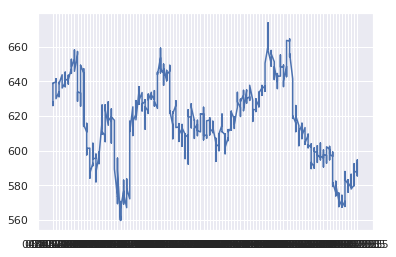

In [27]:
df = train[train['Symbol'] == 'und_129']
df.index = df['Date']
plt.plot(df['MidPrice'])

In [28]:
temp_train = pd.DataFrame()
temp_train['ID'] = train['Date'] + ' ' + train['Symbol']
temp_train['MidPrice'] = train['MidPrice']

temp_test = pd.DataFrame()
temp_test['ID'] = test['Date'] + ' ' + test['Symbol']

In [29]:
# temp_df = pd.DataFrame()
# temp_df['ID'] = test['Date'] + ' ' + test['Symbol']
# temp_df['Time'] = test['Time']
# temp_df['MidPrice'] = pred
# temp_df.to_csv('temp_df.csv', index=False)

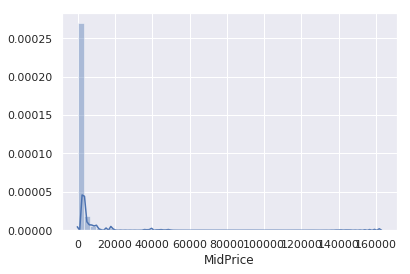

In [30]:
sns.distplot(target)

In [31]:
# Time series Forecasting
from numpy import mean

unique_id = test['Symbol'].unique()
pred = [0] * len(test)
for ids in unique_id:
    
    X = train[train['Symbol'] == ids][feature_names]
    y = train[train['Symbol'] == ids]['MidPrice']
    test_df = test[test['Symbol'] == ids][feature_names]
    predictions = runXGB(np.array(X), y, np.array(test_df))
    x = 0
    for i in range(len(test)):
        if test['Symbol'][i] == ids:
            pred[i] = predictions[x]
            x += 1

In [32]:
temp_df['MidPrice'] = pred
pred = temp_df['MidPrice'].values

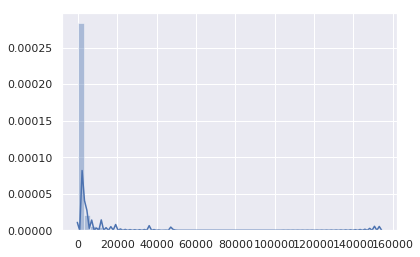

In [33]:
#pred=np.exp(pred)
sns.distplot(pred)

In [34]:
len(pred)

423088

In [35]:
len(temp_df)

423088

In [36]:
ans = []
uids = test['Time'].values ## sample uids time should be used
uniq = temp_df['ID'].unique()
dic = dict()
count = 0
total_return = 0
for sym in uniq:
    temp = temp_df[temp_df['ID'] == sym].reset_index()
    ans_tmp=[]
    for i in range(len(temp)):
        if (temp['Time'][i] >= '09:30') and (temp['Time'][i] <= '15:10'):
            ans_tmp.append(-1)
        else:
            ans_tmp.append(0)
    #ans_tmp = [0] * len(temp)
    price = list(temp[(temp['Time'] >= '09:30') & (temp['Time'] <= '15:10')]['MidPrice'].values)
    #print(ans_tmp)
    transactions = []
    profit = 0
    buy = sell = 0
    A = price
    temp_buy_sell =[0] * len(price)
    for i in range(0,len(A)):
        for j in range(i+1,len(A)):
            if A[i] - A[j] > profit:
                profit = A[i] - A[j]
                buy = i
                sell = j
     
    temp_buy_sell[buy] = -1
    temp_buy_sell[sell] = 1
    total_return += profit
    #print ('Profit:', profit)
    #print(temp_buy_sell)
    x=0
    for i in range(len(ans_tmp)):
        if ans_tmp[i] == -1:
            ans_tmp[i] = temp_buy_sell[x]
            x += 1
            
    #print(sym,ans_tmp)
            
    ans.extend(ans_tmp)

In [37]:
print(count,total_return)

0 213453.79650497437


In [38]:
len(ans)

423088

In [39]:
sample = pd.read_csv('../input/sample-submission/submission_format923c8d6.csv')
sample.drop(['BuySell'],axis=1,inplace=True)

In [40]:
## make submission
sub = pd.DataFrame()
sub['UID'] = test['UID']
sub['BuySell'] = ans

In [41]:
sub = pd.merge(sub,sample, how='inner',on=['UID'])
sub.to_csv('result.csv', index=False)

In [42]:
temp = test[['UID','Date','Time','Symbol']]
temp['MidPrice'] = pred
temp = pd.merge(temp,sample, how='inner',on=['UID'])
temp.to_csv('testcase.csv', index=False)

In [43]:
temp.shape

(394661, 5)

In [44]:
sub.shape

(394661, 2)

In [45]:
sub[sub['UID'] == '23-07-2015 15:30 und_65']

,UID,BuySell
261354,23-07-2015 15:30 und_65,0


In [46]:

# coding: utf-8

# In[7]:


import csv
import json
import sys
import pandas as pd
import numpy as np
import gc
import time


testcase = 'testcase.csv'
user_submission = 'result.csv'


def returns(entry, exit, position):
    """Calculates the returns for the given entry_pt and exit_pt"""
    return (-1) * position * (exit - entry) / entry


def eval_score(stock_prices):
    """
    a : daily returns
    b : number of trades
    """
    
    if len(stock_prices) == 0:
        return 0.0

    # daily returns for the given stock
    a = sum(stock_prices)
    # number of trades for the given stock
    b = len(stock_prices)

    # check for min number of trades per stock
    # There are 160 unique stocks
    print('a = ',a)
    print('b = ',b)
    
    if (b/160) >= 20:
        score = (a - (b * 0.12 / 100)) * b
    else:
        score = 0.0

    return score


def daily_return_per_stock(stockdata):
    stock_prices = []
    entry_pt = 0
    exit_pt = 0
    exit_pt_set = False
    entry_pt_set = False
    prev_date = stockdata['Date'][0]
    prev_buy_sell = stockdata['BuySell'][0]
    for i in range(stockdata.shape[0]):
        # For same day calculate daily returns for the given stock
        if stockdata['Time'][i] >= '15:15' and stockdata['BuySell'][i] != 0:
            raise Exception('The BuySell decision should be squared off before 15:15 PM. Check UID : {}'.format(
                stockdata['UID'][i]))
        #print(i, abs(stockdata['BuySell'][i] - prev_buy_sell))
        if (abs(stockdata['BuySell'][i] - prev_buy_sell) == 1):
            # print(i, stockdata['Date'][i])
            if entry_pt_set:
                exit_pt = stockdata['MidPrice'][i]
                # Calculating the position (long or short)
                position = stockdata['BuySell'][i] - prev_buy_sell
                try:
                    #print('entry_pt {}, exit_pt {}, position {}'.format(entry_pt, exit_pt, position))
                    r = returns(entry_pt, exit_pt, position)
                    
                except:
                    r = 0
                stock_prices.append(r)
                entry_pt_set = False
            else:
                entry_pt = stockdata['MidPrice'][i]
                entry_pt_set = True
        prev_date = stockdata['Date'][i]
        prev_buy_sell = stockdata['BuySell'][i]
    return stock_prices


def filter_by_date_and_stock(stockdata, stock_name, date):
    """
    Provides details of the given stock name for the given date 
    """
    stockdata = stockdata[stockdata['Symbol'] == stock_name]
    stockdata.reset_index(inplace=True, drop=True)
    stockdata = stockdata[stockdata['Date'] == date]
    stockdata.reset_index(inplace=True, drop=True)
    return stockdata


def calculate_stock_scores(data):
    ustocks = data['Symbol'].unique()
    udates = data['Date'].unique()
    stock_scores = []
    for stock in ustocks:
        
        for date in udates:
            temp = filter_by_date_and_stock(data, stock, date)
            daily_returns = daily_return_per_stock(temp)
            
            stock_scores.extend(daily_returns)
        
    stock_scores = eval_score(stock_scores)

    return stock_scores


def verify_submission():
#     if not user_submission.endswith('.csv'):
#         raise Exception(
#             'Please upload a csv file containing predictions in the format given in the sample submission file')

    fp_submission = sub#.head(5)#pd.read_csv(user_submission)
    fp_testcase = temp#.head(5)#pd.read_csv(testcase)

#     if fp_submission.shape[0] != 394661:
#         raise Exception('File does not contain the correct number of rows')
    if list(fp_submission.columns) != list(['UID', 'BuySell']):
        raise Exception('File does not contain correct headers, please check sample_submission file')
    
    ids_not_present = set(fp_testcase['UID']) - set(fp_submission['UID'])
    for idx in list(ids_not_present):
        key_not_found = idx
        raise Exception('File does not contain prediction for id:{0}'.format(key_not_found))

    data = fp_testcase.merge(fp_submission, on='UID')
    # Merging on test case file which contains the following headers:
    # UID, Date, Time, Symbol and MidPrice     
    del fp_submission, fp_testcase
    gc.collect()
    start_time = time.time()
    score = calculate_stock_scores(data)
    end_time = time.time()
    print("{0:.6f} ".format(score))
    


try:
    verify_submission()
except Exception as e:
    sys.exit(e.args[0])


a =  42.08449664284963
b =  10462
308943.871077 
